In [ ]:
import glob
import os
import pathlib

import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import functional as F

from torchvision import transforms
from torchinfo import torchinfo
from tqdm import tqdm
import matplotlib.pyplot as plt

import albumentations as A
import torch.nn.functional as F

from PIL import Image

import torchmetrics
from torchvision.utils import save_image, make_grid
import cv2
from torch.autograd import Variable


device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
data_dir = '../Datasets/Infilling/Dataset/00000'

In [ ]:
files = []

for item in tqdm(pathlib.Path(data_dir).rglob("*.png")):
    if item.is_file():
        files.append(str(item))

14983it [00:01, 7503.96it/s]


In [ ]:
testfiles = []

for item in tqdm(pathlib.Path('../Datasets/Infilling/Dataset/15000').rglob("*.png")):
    if item.is_file():
        testfiles.append(str(item))

1000it [00:00, 7740.27it/s]


Each image has a 1024 x 1024 dimension with 3 channels

In [ ]:
size = (128, 128)
mask_size = 64

resize_transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.Resize(size, interpolation = torchvision.transforms.InterpolationMode.BICUBIC, antialias = False),
    #transforms.Normalize(0.5, 0.5)
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmentation = A.Compose([
        A.augmentations.dropout.coarse_dropout.CoarseDropout(
        max_holes = 4,
        max_height = 100,
        max_width = 100,
        min_holes = 2,
        min_height = 30,
        min_width = 30,
        fill_value = 0,
        always_apply = True
    )
])


In [ ]:
class GANDataset(Dataset):
    def __init__(self, paths, transform = None):
        self.filepaths = paths
        self.transform = transform

        self.mask_gen = np.ones(size, dtype = np.float32)
        self.images = [resize_transform(torchvision.io.read_image(x).float()/255.0) for x in tqdm(paths)]
        self.images = torch.stack(self.images)
    
    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        # img = resize_transform(torchvision.io.read_image(self.filepaths[idx]).float()/255.0)
        img = self.images[idx]
        
        if self.transform is not None:
            img = self.transform(img)
        
        mask = torch.tensor(augmentation(image = self.mask_gen)['image'])[None, :, :]
        mask_img = mask*img

        
        
        return img, mask_img, mask

In [ ]:
# train_dataset = GANDataset(files, None)
# test_dataset = GANDataset(testfiles, None)

In [ ]:
# with open("train_data.pth", 'wb') as f:
#     torch.save(train_dataset, f)

# with open("test_data.pth", 'wb') as f:
#     torch.save(test_dataset, f)

# with open("train_data.pth", 'rb') as f:
    # train_dataset = torch.load(f)

# with open("test_data.pth", 'rb') as f:
    # test_dataset = torch.load(f)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, img_size=100, mask_size=50, mode="train"):
        self.transform = transforms_
        self.img_size = img_size
        self.mask_size = mask_size
        self.mode = mode
        self.files = glob.glob("%s/*.jpg" % root)
        self.files = self.files[:-4000] if mode == "train" else self.files[-4000:]

    def apply_random_mask(self, img):
        """Randomly masks image"""
        y1, x1 = np.random.randint(0, self.img_size - self.mask_size, 2)
        y2, x2 = y1 + self.mask_size, x1 + self.mask_size
        masked_part = img[:, y1:y2, x1:x2]
        masked_img = img.clone()
        masked_img[:, y1:y2, x1:x2] = 1

        return masked_img, masked_part

    def apply_center_mask(self, img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate
        i = (self.img_size - self.mask_size) // 2
        masked_img = img.clone()
        masked_img[:, i : i + self.mask_size, i : i + self.mask_size] = 1

        return masked_img, i

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        img = self.transform(img)

        if self.mode == "train":
            # For training data perform random mask
            masked_img, aux = self.apply_random_mask(img)
        else:
            # For test data mask the center of the image
            masked_img, aux = self.apply_center_mask(img)

        return img, masked_img, aux

    def __len__(self):
        return len(self.files)

In [ ]:
train_dataset = ImageDataset('../Datasets/celeba/img_align_celeba/', transforms_ = resize_transform, mask_size=mask_size)
test_dataset = ImageDataset('../Datasets/celeba/img_align_celeba/', transforms_ = resize_transform, mode = 'test', mask_size=mask_size)


In [ ]:
train_dataset[6][0].shape

torch.Size([3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


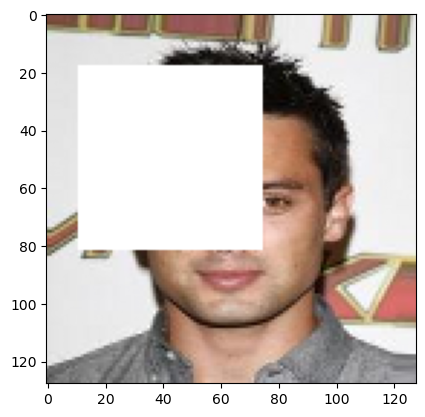

In [ ]:
plt.imshow(train_dataset[6][1].permute(1, 2, 0).numpy())

In [ ]:
BATCH_SIZE = 100
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE)

In [ ]:
# taken from https://www.kaggle.com/code/balraj98/context-encoder-gan-for-image-inpainting-pytorch/notebook

class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        def downsample(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def upsample(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        self.model = nn.Sequential(
            *downsample(channels, 64, normalize=False),
            *downsample(64, 64),
            *downsample(64, 128),
            *downsample(128, 256),
            *downsample(256, 512),
            nn.Conv2d(512, 4000, 1),
            *upsample(4000, 512),
            *upsample(512, 256),
            *upsample(256, 128),
            *upsample(128, 64),
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = channels
        for out_filters, stride, normalize in [(64, 2, False), (128, 2, True), (256, 2, True), (512, 1, True)]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
# train_dataset.transform = transforms.Compose([
#     transforms.RandomAffine(30, (0.2, 0.2), (1, 1.3), 20),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomHorizontalFlip()
# ]
# )

# train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle = True)

In [ ]:
generator = Generator(channels=3).to(device)
discriminator = Discriminator(channels=3).to(device)

# Loss function
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()

# Weight initialisation
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimiser
optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-3)

Tensor = torch.cuda.FloatTensor # if device.type == 'cuda' else torch.FloatTensor

patch_h, patch_w = int(mask_size / 2 ** 3), int(mask_size / 2 ** 3)
patch = (1, patch_h, patch_w)

In [ ]:
def save_sample(batches_done):
    samples, masked_samples, i = next(iter(test_dataloader))
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    i = i[0].item()  # Upper-left coordinate of mask
    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples[:, :, i : i + mask_size, i : i + mask_size] = gen_mask
    # Save sample
    sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    save_image(sample, "images/%d.png" % batches_done, nrow=6, normalize=True)

In [ ]:
gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []
sample_interval = 100

g_weight = 0.015

EPOCHS = 20

for epoch in range(EPOCHS):
    
    ### Training ###
    gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    for i, (imgs, masked_imgs, masked_parts) in enumerate(tqdm_bar):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False).to(device)

        # Configure input
        imgs = imgs.to(device)
        masked_imgs = masked_imgs.to(device)
        masked_parts = masked_parts.to(device)

        ## Train Generator ##
        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_parts = generator(masked_imgs)

        # Adversarial and pixelwise loss
        g_adv = adversarial_loss(discriminator(gen_parts), valid)
        g_pixel = pixelwise_loss(gen_parts, masked_parts)
        # Total loss
        g_loss = g_weight * g_adv + (1-g_weight) * g_pixel

        g_loss.backward()
        optimizer_G.step()

        ## Train Discriminator ##
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(masked_parts), valid)
        fake_loss = adversarial_loss(discriminator(gen_parts.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
        
        gen_adv_loss, gen_pixel_loss, disc_loss
        gen_adv_losses, gen_pixel_losses, disc_losses, counter
        
        gen_adv_loss += g_adv.item()
        gen_pixel_loss += g_pixel.item()
        gen_adv_losses.append(g_adv.item())
        gen_pixel_losses.append(g_pixel.item())
        disc_loss += d_loss.item()
        disc_losses.append(d_loss.item())
        counter.append(i*BATCH_SIZE + imgs.size(0) + epoch*len(train_dataloader.dataset))
        tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1))
        
        # Generate sample at sample interval
        batches_done = epoch * len(train_dataloader) + i
        if batches_done % sample_interval == 0:
            save_sample(batches_done)
            torch.save(generator.state_dict(), 'gen_temp.pth')
            torch.save(discriminator.state_dict(), 'disc_temp.pth')

Training Epoch 4 :  65%|██████▌   | 1294/1986 [04:55<02:26,  4.72it/s, disc_loss=0.171, gen_adv_loss=0.475, gen_pixel_loss=0.102]

In [ ]:
torch.save(generator.state_dict(), 'gen_state_dict.pth')
torch.save(discriminator.state_dict(), 'disc_state_dict.pth')

In [ ]:
discriminator(gen_parts).shape

torch.Size([125, 1, 8, 8])

In [ ]:
valid.shape

torch.Size([125, 1, 10, 10])

In [ ]:
# # Training loop


# EPOCHS = 20
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
# loss = nn.L1Loss()


# for epoch_num in range(EPOCHS):

#     total_acc_train = 0
#     total_loss_train = 0

#     for train_image, masked_image, mask in tqdm(train_dataloader):
#           optimizer.zero_grad()
          
#           train_image = train_image.to(device)
#           masked_image = masked_image.to(device)
        
#           output = model(masked_image)['reconstruction']
#           output = F.sigmoid(output)

#           batch_loss = loss(output, train_image)
#           batch_loss.backward()
#           optimizer.step()
#           total_loss_train += batch_loss.item()
        
#           #train_img_acc(output, train_image)

#     total_loss_val = 0

#     with torch.no_grad():
#         #Validation
#         for train_image, masked_image, mask in test_dataloader:
#             train_image = train_image.to(device)
#             masked_image = masked_image.to(device)
            
#             output = model(masked_image)['reconstruction']
#             output = F.sigmoid(output)

#             batch_loss = loss(output, train_image)
#             # batch_loss.backward()
#             # optimizer.step()
#             total_loss_val += batch_loss.item()
        
#     avg_train_loss = total_loss_train/len(train_dataset)

#     avg_val_loss = total_loss_val/len(test_dataset)


#     print("Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}".format(epoch_num+1, EPOCHS, avg_train_loss*BATCH_SIZE, avg_val_loss*BATCH_SIZE))
#     torch.save(model.state_dict(), 'temp_state_small.pth')

100%|██████████| 120/120 [01:23<00:00,  1.44it/s]


Epoch [1/20], Train Loss: 0.1475, Val Loss: 0.1053


100%|██████████| 120/120 [01:23<00:00,  1.44it/s]


Epoch [2/20], Train Loss: 0.0953, Val Loss: 0.0928


100%|██████████| 120/120 [01:24<00:00,  1.43it/s]


Epoch [3/20], Train Loss: 0.0833, Val Loss: 0.0820


100%|██████████| 120/120 [01:24<00:00,  1.42it/s]


Epoch [4/20], Train Loss: 0.0755, Val Loss: 0.0751


100%|██████████| 120/120 [01:24<00:00,  1.42it/s]


Epoch [5/20], Train Loss: 0.0688, Val Loss: 0.0704


100%|██████████| 120/120 [01:19<00:00,  1.50it/s]


Epoch [6/20], Train Loss: 0.0655, Val Loss: 0.0678


100%|██████████| 120/120 [01:20<00:00,  1.50it/s]


Epoch [7/20], Train Loss: 0.0636, Val Loss: 0.0670


100%|██████████| 120/120 [01:20<00:00,  1.49it/s]


Epoch [8/20], Train Loss: 0.0625, Val Loss: 0.0675


100%|██████████| 120/120 [01:20<00:00,  1.49it/s]


Epoch [9/20], Train Loss: 0.0617, Val Loss: 0.0649


100%|██████████| 120/120 [01:19<00:00,  1.51it/s]


Epoch [10/20], Train Loss: 0.0606, Val Loss: 0.0638


100%|██████████| 120/120 [01:18<00:00,  1.53it/s]


Epoch [11/20], Train Loss: 0.0596, Val Loss: 0.0625


100%|██████████| 120/120 [01:18<00:00,  1.54it/s]


Epoch [12/20], Train Loss: 0.0585, Val Loss: 0.0626


100%|██████████| 120/120 [01:18<00:00,  1.53it/s]


Epoch [13/20], Train Loss: 0.0570, Val Loss: 0.0594


100%|██████████| 120/120 [01:18<00:00,  1.54it/s]


Epoch [14/20], Train Loss: 0.0558, Val Loss: 0.0581


100%|██████████| 120/120 [01:18<00:00,  1.54it/s]


Epoch [15/20], Train Loss: 0.0553, Val Loss: 0.0583


100%|██████████| 120/120 [01:18<00:00,  1.54it/s]


Epoch [16/20], Train Loss: 0.0545, Val Loss: 0.0567


100%|██████████| 120/120 [01:17<00:00,  1.54it/s]


Epoch [17/20], Train Loss: 0.0535, Val Loss: 0.0559


100%|██████████| 120/120 [01:18<00:00,  1.54it/s]


Epoch [18/20], Train Loss: 0.0531, Val Loss: 0.0559


100%|██████████| 120/120 [01:18<00:00,  1.53it/s]


Epoch [19/20], Train Loss: 0.0526, Val Loss: 0.0552


100%|██████████| 120/120 [01:17<00:00,  1.54it/s]


Epoch [20/20], Train Loss: 0.0522, Val Loss: 0.0558


In [ ]:
# import torch
# import torch.nn as nn

# def add_module(self, module):
#     self.add_module(str(len(self) + 1), module)

# torch.nn.Module.add = add_module


# def conv(in_f, out_f, kernel_size, stride=1, pad='zero'):
#     padder = None
#     to_pad = int((kernel_size - 1) / 2)
#     if pad == 'reflection':
#         padder = nn.ReflectionPad2d(to_pad)
#         to_pad = 0
  
#     convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=False)

#     layers = filter(lambda x: x is not None, [padder, convolver])
#     return nn.Sequential(*layers)

# def decodernw(
#         num_output_channels=3, 
#         num_channels_up=[128]*5, 
#         filter_size_up=1,
#         need_sigmoid=True, 
#         pad ='reflection', 
#         upsample_mode='bilinear', 
#         act_fun=nn.ReLU(), # nn.LeakyReLU(0.2, inplace=True) 
#         bn_before_act = False,
#         bn_affine = True,
#         upsample_first = True,
#         ):
    
#     num_channels_up = num_channels_up + [num_channels_up[-1],num_channels_up[-1]]
#     n_scales = len(num_channels_up) 
    
#     if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
#         filter_size_up   = [filter_size_up]*n_scales
#     model = nn.Sequential()

    
#     for i in range(len(num_channels_up)-1):
        
#         if upsample_first:
#             model.add(conv( num_channels_up[i], num_channels_up[i+1],  filter_size_up[i], 1, pad=pad))
#             if upsample_mode!='none' and i != len(num_channels_up)-2:
#                 model.add(nn.Upsample(scale_factor=2, mode=upsample_mode))
#             #model.add(nn.functional.interpolate(size=None,scale_factor=2, mode=upsample_mode))	
#         else:
#             if upsample_mode!='none' and i!=0:
#                 model.add(nn.Upsample(scale_factor=2, mode=upsample_mode))
#             #model.add(nn.functional.interpolate(size=None,scale_factor=2, mode=upsample_mode))	
#             model.add(conv( num_channels_up[i], num_channels_up[i+1],  filter_size_up[i], 1, pad=pad))        
        
#         if i != len(num_channels_up)-1:	
#             if(bn_before_act): 
#                 model.add(nn.BatchNorm2d( num_channels_up[i+1] ,affine=bn_affine))
#             model.add(act_fun)
#             if(not bn_before_act): 
#                 model.add(nn.BatchNorm2d( num_channels_up[i+1], affine=bn_affine))
      
#     model.add(conv( num_channels_up[-1], num_output_channels, 1, pad=pad))
#     if need_sigmoid:
#         model.add(nn.Sigmoid())
    
#     return model



# # Residual block
# class ResidualBlock(nn.Module):
#     def __init__(self, in_f, out_f):
#         super(ResidualBlock, self).__init__()
#         self.conv = nn.Conv2d(in_f, out_f, 1, 1, padding=0, bias=False)
        
#     def forward(self, x):
#         residual = x
#         out = self.conv(x)
#         out += residual
#         return out

# def resdecoder(
#         num_output_channels=3, 
#         num_channels_up=[128]*5, 
#         filter_size_up=1,
#         need_sigmoid=True, 
#         pad='reflection', 
#         upsample_mode='bilinear', 
#         act_fun=nn.ReLU(), # nn.LeakyReLU(0.2, inplace=True) 
#         bn_before_act = False,
#         bn_affine = True,
#         ):
    
#     num_channels_up = num_channels_up + [num_channels_up[-1],num_channels_up[-1]]
#     n_scales = len(num_channels_up) 
    
#     if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
#         filter_size_up   = [filter_size_up]*n_scales

#     model = nn.Sequential()

#     for i in range(len(num_channels_up)-2):
        
#         model.add( ResidualBlock( num_channels_up[i], num_channels_up[i+1]) )
        
#         if upsample_mode!='none':
#             model.add(nn.Upsample(scale_factor=2, mode=upsample_mode))	
#             #model.add(nn.functional.interpolate(size=None,scale_factor=2, mode=upsample_mode))	
        
#         if i != len(num_channels_up)-1:	
#             model.add(act_fun)
#             #model.add(nn.BatchNorm2d( num_channels_up[i+1], affine=bn_affine))
                
#     # new
#     model.add(ResidualBlock( num_channels_up[-1], num_channels_up[-1]))
#     #model.add(nn.BatchNorm2d( num_channels_up[-1] ,affine=bn_affine))
#     model.add(act_fun)
#     # end new
    
#     model.add(conv( num_channels_up[-1], num_output_channels, 1, pad=pad))
    
#     if need_sigmoid:
#         model.add(nn.Sigmoid())
    
#     return model

In [ ]:
torch.save(model.state_dict(), 'deit_tiny.pth')

# with open("deit_tiny.pth", 'rb') as f:
    # model.load_state_dict(torch.load(f))

In [ ]:
train_dataset.transform = None

In [ ]:
img, mask, _ = test_dataset[50]

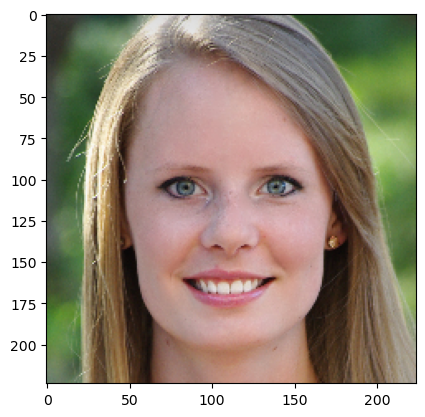

In [ ]:
plt.imshow(img.permute(1, 2, 0).numpy())

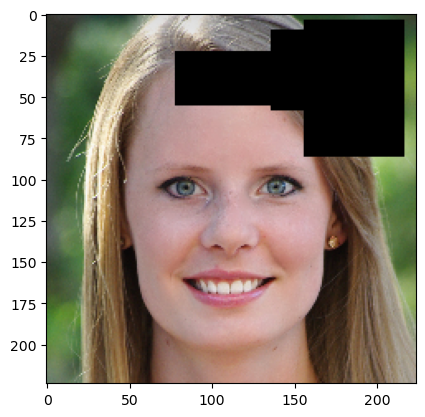

In [ ]:
plt.imshow(mask.permute(1, 2, 0).numpy())

In [ ]:
out = F.sigmoid(model(img[None, ...].to(device))['reconstruction'])

In [ ]:
lowres_out = out[0].permute(1, 2, 0).cpu().detach().numpy()

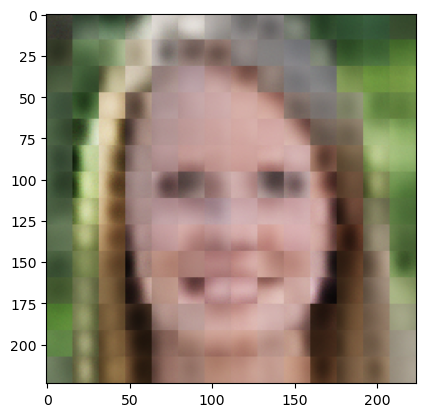

In [ ]:
plt.imshow(out[0].permute(1, 2, 0).cpu().detach().numpy())

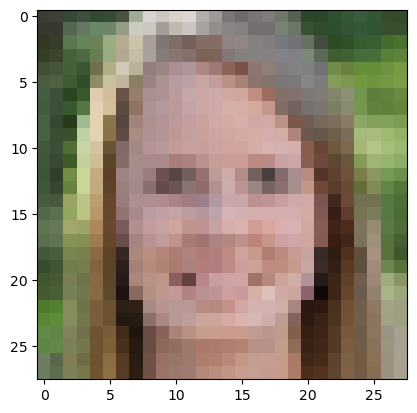

In [ ]:
plt.imshow(cv2.resize(lowres_out, (28, 28)))

In [ ]:
import PIL
import requests
import torch
from io import BytesIO

from diffusers import StableDiffusionInpaintPipeline

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
)

# def download_image(url):
#     response = requests.get(url)
#     return PIL.Image.open(BytesIO(response.content)).convert("RGB")

# img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
# mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

# init_image = download_image(img_url).resize((512, 512))
# mask_image = download_image(mask_url).resize((512, 512))

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")
# pipe.enable_attention_slicing()
# Workaround for not accepting attention shape using VAE for Flash Attention
# pipe.vae.enable_xformers_memory_efficient_attention(attention_op=None)

unet\diffusion_pytorch_model.safetensors not found
c:\ProgramData\Anaconda3\envs\torchnew\Lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
resize_512 = transforms.Resize((512, 512))

In [ ]:
%%time
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image)

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: total: 5.28 s
Wall time: 3.01 s


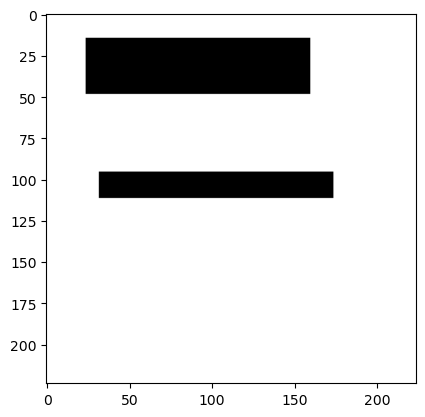

In [ ]:
augmentation = A.Compose([
        A.augmentations.dropout.coarse_dropout.CoarseDropout(
        max_holes = 2,
        max_height = 50,
        max_width = 150,
        min_holes = 1,
        min_height = 10,
        min_width = 100,
        fill_value = 0,
        always_apply = True
    )
])

testmask = torch.tensor(augmentation(image =np.ones(size, dtype = np.float32))['image'])[None, :, :]
plt.imshow(testmask.permute(1, 2, 0).cpu().detach().numpy(),'gray')

In [ ]:
masked_img = resize_transform(torchvision.io.read_image('test.jpg')).float() * testmask /255.
decoded = model(masked_img[None, ...].to(device))

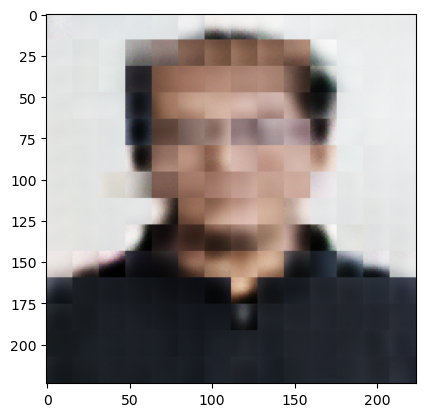

In [ ]:
plt.imshow(F.sigmoid(decoded['reconstruction'][0]).permute(1, 2, 0).cpu().detach().numpy())

In [ ]:
imshow

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [ ]:
img = cv2.imread('cat_damaged.png')
  
# Load the mask.
mask = cv2.imread('cat_mask.png', 0)
  
# Inpaint.
dst = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)
  
# Write the output.
cv2.imwrite('cat_inpainted.png', dst)